# Exploring Blood Donation Data #

This project explores the blood donations dataset used in [this Driven Data competition](https://www.drivendata.org/competitions/2/page/5/). The data is taken from a mobile blood donation vehicle in Taiwan that collects blood from donors at various universities. Using a linear regression model, we will attempt to predict the probability that a previous donor will donate again the next time the vehicle arrives on campus. We will also determine whether this type of model is suitable for this problem, or whether we will need a different model in order to make successful predictions.

## Contents ##
* #### Part 1: Exploring the Training and Test Data ####
    * Initial Data Exploration
    * Data Munging
    * Further Data Exploration
    * Linear Modeling
* #### Part 2: Prediction ####
    * Conclusion

## Part 1: Exploring the Training and Test Data ##

The data has already been split into two separate files, one for the training data and one for the test data. First, we'll read in the data and do some exploratory data analysis to get a sense of our training and test data.

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import scipy.stats as stats
from scipy.stats import skew
import missingno as msno
import warnings
from sklearn import linear_model
import statsmodels.formula.api as sm
from sklearn.metrics import mean_squared_error
from sklearn import preprocessing
warnings.simplefilter(action = 'ignore', category = (FutureWarning, UserWarning))

### Initial Data Exploration ###

In [2]:
# Read in the data.
train = pd.read_csv('training.csv', index_col='Unnamed: 0')
test = pd.read_csv('test.csv', index_col='Unnamed: 0')

In [3]:
# Check shape.
print(train.shape)
print(test.shape)

(576, 5)
(200, 4)


In [4]:
# Sample of the training data.
train.head(3)

,Months since Last Donation,Number of Donations,Total Volume Donated (c.c.),Months since First Donation,Made Donation in March 2007
619,2,50,12500,98,1
664,0,13,3250,28,1
441,1,16,4000,35,1


In [5]:
# Sample of the test data.
test.head(3)

,Months since Last Donation,Number of Donations,Total Volume Donated (c.c.),Months since First Donation
659,2,12,3000,52
276,21,7,1750,38
263,4,1,250,4


In [6]:
# Rename the columns to make them easier to work with.
train = train.rename(columns={'Months since Last Donation' : 'last donation (mo)',
                              'Number of Donations' : 'num donations', 
                              'Total Volume Donated (c.c.)' : 'total volume (cc)',
                              'Months since First Donation' : 'first donation (mo)',
                              'Made Donation in March 2007' : 'donated (3/07)'})

test = test.rename(columns={'Months since Last Donation' : 'last donation (mo)',
                              'Number of Donations' : 'num donations', 
                              'Total Volume Donated (c.c.)' : 'total volume (cc)',
                              'Months since First Donation' : 'first donation (mo)'})

In [7]:
train.head(3)

,last donation (mo),num donations,total volume (cc),first donation (mo),donated (3/07)
619,2,50,12500,98,1
664,0,13,3250,28,1
441,1,16,4000,35,1


In [8]:
test.head(3)

,last donation (mo),num donations,total volume (cc),first donation (mo)
659,2,12,3000,52
276,21,7,1750,38
263,4,1,250,4


Use the `corr()` function to get a sense of how the features and label are correlated with one another.

In [9]:
# Examine correlation matrix.
train.corr()

,last donation (mo),num donations,total volume (cc),first donation (mo),donated (3/07)
last donation (mo),1.000000,-0.159731,-0.159731,0.186899,-0.261234
num donations,-0.159731,1.000000,1.000000,0.622116,0.220615
total volume (cc),-0.159731,1.000000,1.000000,0.622116,0.220615
first donation (mo),0.186899,0.622116,0.622116,1.000000,-0.019819
donated (3/07),-0.261234,0.220615,0.220615,-0.019819,1.000000


On first glance, we can see that `num donations` and `total volume (cc)` are perfectly correlated, which makes intuitive sense. However, this will be problematic for our prediction model. We will likely need to disregard one of these factors in our final model.

It also looks like `first donation (mo)` is strongly correlated with `num donations` and `total volume (cc)`. This again makes intuitive sense, since the more time that has elapsed since your first donation, the more time you have had to make new donations and increase your total volume donated. We may need to watch out for collinearity here as well, though it's possible that when we remove one of the perfectly correlated features, the `0.62` correlation that is left (with `first donation (mo)` will be okay.

No individual feature appears to be strongly correlated with whether or not a person has donated (the best being the negative correlation with `last donation (mo)` of `-0.26`), but hopefully we can use a combination of features to make reasonable predictions.

We will explore these relationships in much greater detail later on.

### Data Munging ###

First, let's find out whether we have any missing values in our training or test datasets.

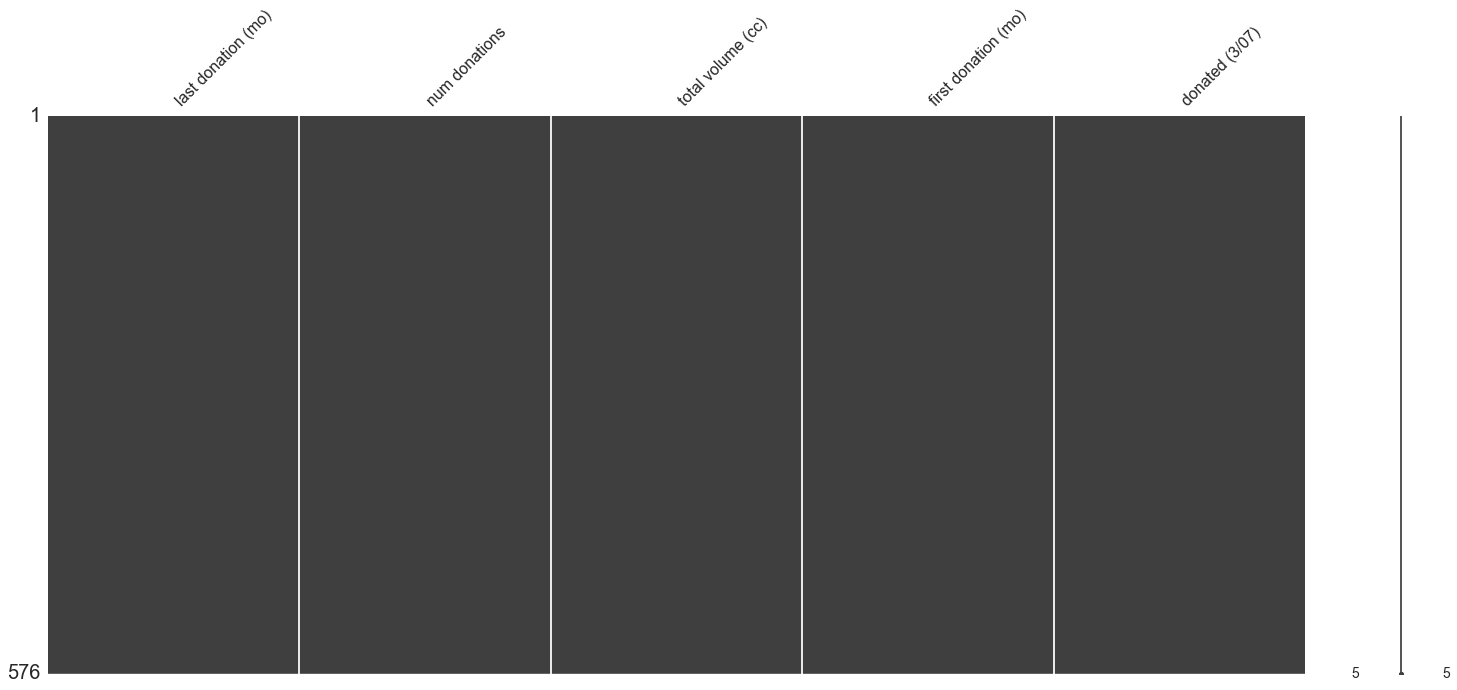

In [10]:
# Visual check for missing training data.
msno.matrix(train)

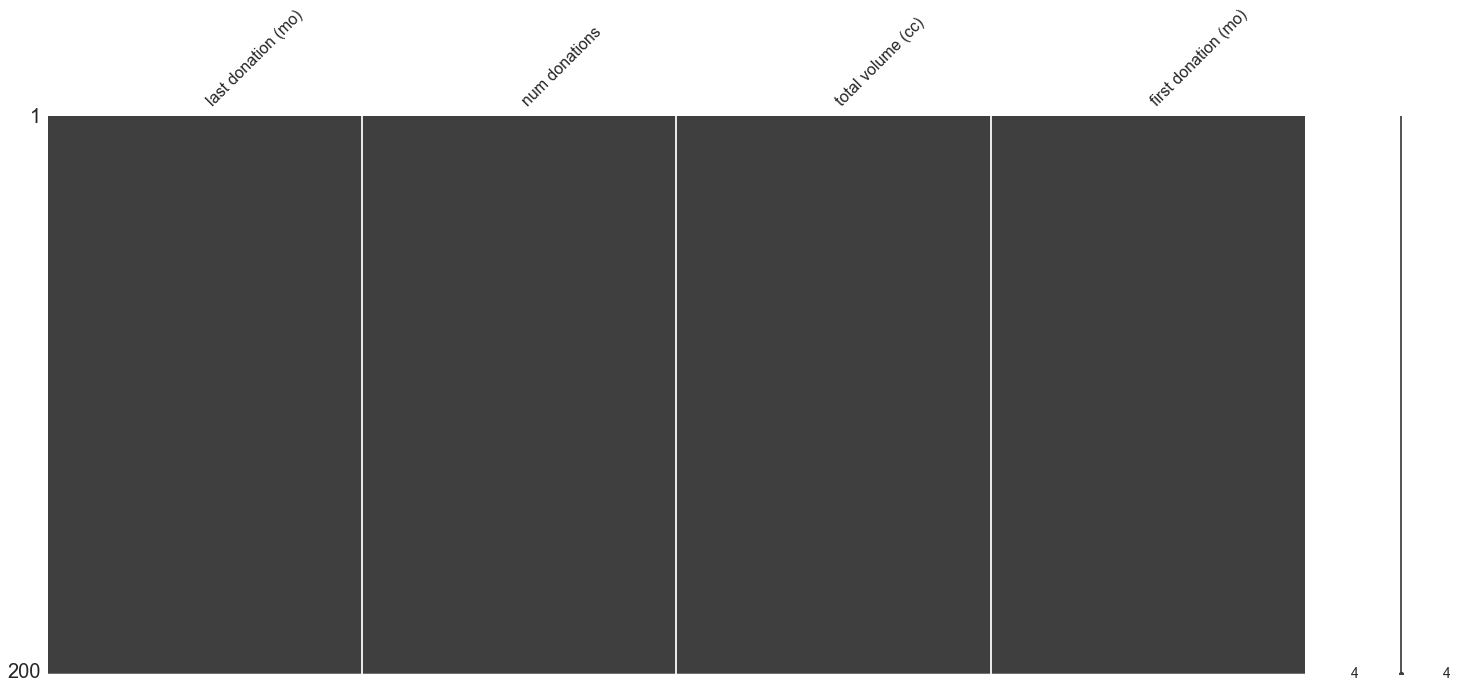

In [11]:
# Visual check for missing test data.
msno.matrix(test)

There do not appear to be any missing values, but let's double check:

In [12]:
# Ensure no missing data.
print(train.isnull().sum(), '\n')
print(test.isnull().sum())

last donation (mo)     0
num donations          0
total volume (cc)      0
first donation (mo)    0
donated (3/07)         0
dtype: int64 

last donation (mo)     0
num donations          0
total volume (cc)      0
first donation (mo)    0
dtype: int64


Now, let's take a look at how the data is distributed using the `describe()` function, density plots, and box plots.

In [13]:
# Examine training set summary statistics.
train.describe()

,last donation (mo),num donations,total volume (cc),first donation (mo),donated (3/07)
count,576.000000,576.000000,576.000000,576.000000,576.000000
mean,9.439236,5.427083,1356.770833,34.050347,0.239583
std,8.175454,5.740010,1435.002556,24.227672,0.427200
min,0.000000,1.000000,250.000000,2.000000,0.000000
25%,2.000000,2.000000,500.000000,16.000000,0.000000
50%,7.000000,4.000000,1000.000000,28.000000,0.000000
75%,14.000000,7.000000,1750.000000,49.250000,0.000000
max,74.000000,50.000000,12500.000000,98.000000,1.000000


Some of these values could indicate outliers but let's dig into the numbers a bit more with a few visual representations of how the data is distributed.

#### Density Plots ####

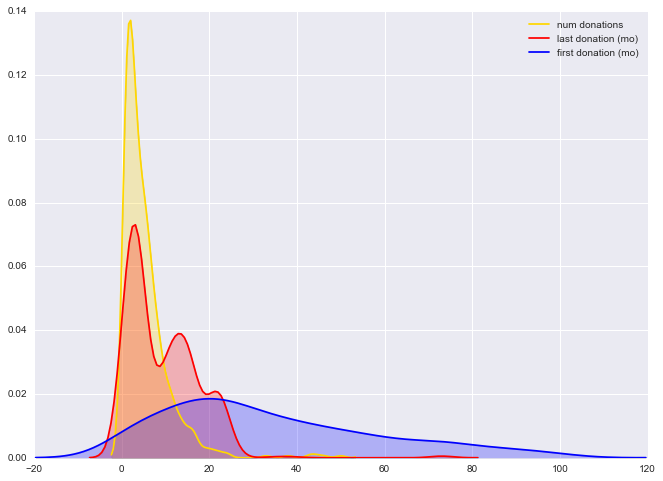

In [14]:
# Examine density plots for last donation (mo), num donations, and first donation (mo).
fig = plt.figure(figsize=(11,8))
ax1 = fig.add_subplot(111)
ax2 = fig.add_subplot(111)
ax3 = fig.add_subplot(111)
sns.kdeplot(train['num donations'], ax=ax1, shade=True, color='gold')
sns.kdeplot(train['last donation (mo)'], ax=ax2, shade=True, color='r')
sns.kdeplot(train['first donation (mo)'], ax=ax3, shade=True, color='b')

Note that even though we have negative x-values, this does not indicate negative values for `first donation (mo)` or `last donation (mo)`, but is instead related to how the KDE plots function.

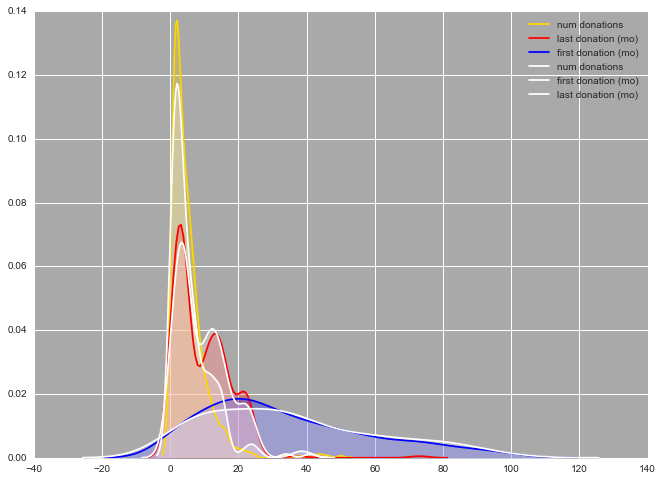

In [15]:
# Overlay test data.
fig = plt.figure(figsize=(11,8))
ax1 = fig.add_subplot(111)
ax2 = fig.add_subplot(111)
ax3 = fig.add_subplot(111)
ax4 = fig.add_subplot(111)
ax4.set_axis_bgcolor('darkgray')
sns.kdeplot(train['num donations'], ax=ax1, shade=True, color='gold')
sns.kdeplot(train['last donation (mo)'], ax=ax2, shade=True, color='r')
sns.kdeplot(train['first donation (mo)'], ax=ax3, shade=True, color='b')
sns.kdeplot(test['num donations'], ax=ax4, shade=True, color='white')
sns.kdeplot(test['first donation (mo)'], ax=ax4, shade=True, color='white')
sns.kdeplot(test['last donation (mo)'], ax=ax4, shade=True, color='white')

Just by looking at this plot, it seems possible that we have an outlier or two in the `last donation (mo)` column, since the red density plot extends pretty far beyond the corresponding test data (white) density plot. However, since these don't seem like unreasonable numbers (80 months since last donation equates to roughly 6.5 years), we'll leave them in the dataset for the time being.

The training data density plots for `first donation (mo)` and `num donations` match the density plots for the corresponding test data fairly well, so we won't treat the extreme data points in the training set as outliers.

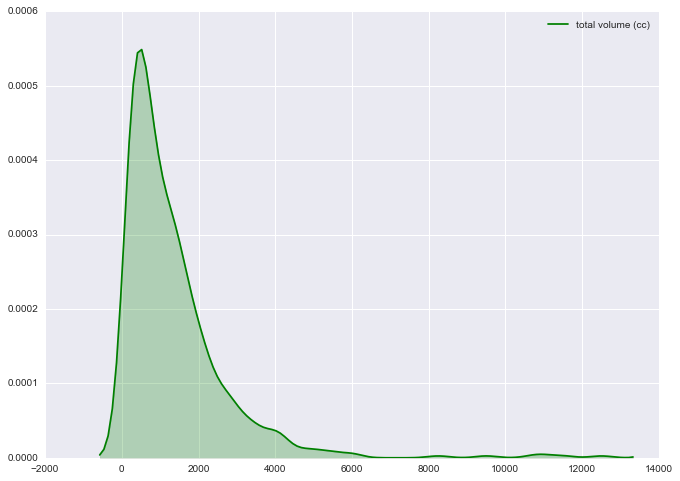

In [16]:
# Examine density plot for total volume (cc), which is on a very different scale.
fig = plt.figure(figsize=(11,8))
ax1 = fig.add_subplot(111)
sns.kdeplot(train['total volume (cc)'], ax=ax1, shade=True, color='green')

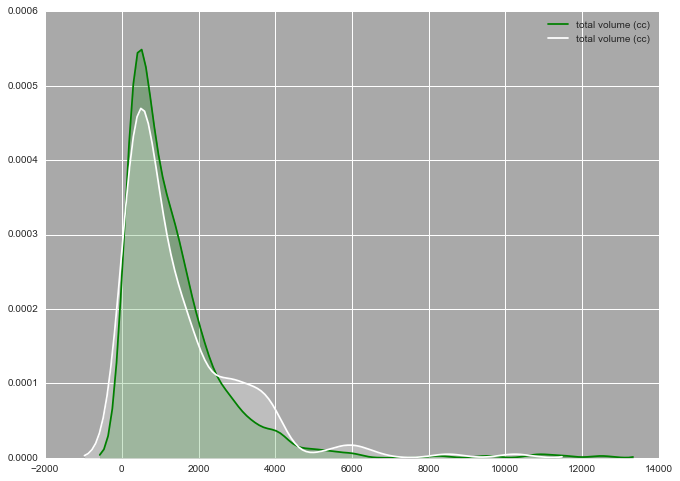

In [17]:
# Overlay test data.
fig = plt.figure(figsize=(11,8))
ax1 = fig.add_subplot(111)
ax2 = fig.add_subplot(111)
ax2.set_axis_bgcolor('darkgray')
sns.kdeplot(train['total volume (cc)'], ax=ax1, shade=True, color='green')
sns.kdeplot(test['total volume (cc)'], ax=ax2, shade=True, color='white')

Once again, though the extreme values in our training data for `total volume (cc)` might be considered outliers, our test data is distributed fairly similarly so we will leave these values in the training set.

#### Box Plots ####

Next, we can use box plots to get a sense of how the training data is distributed between people who donated and people who did not.

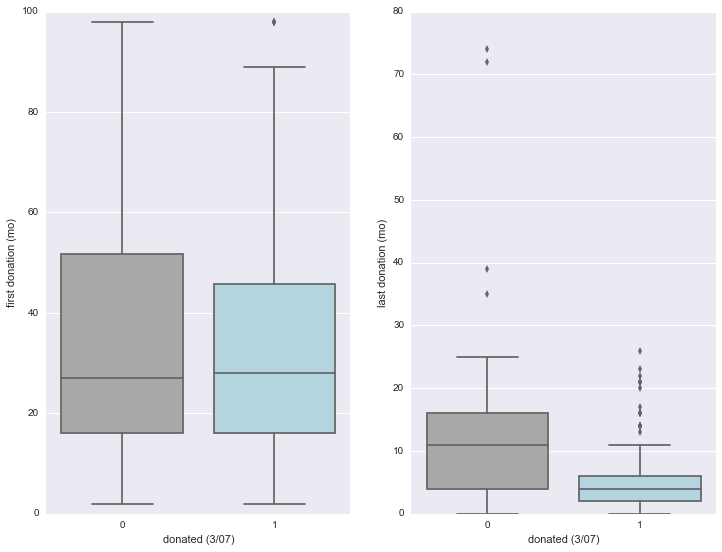

In [18]:
# Examine box plots for first donation and last donation.
fig = plt.figure(figsize=(12,9))
ax1 = fig.add_subplot(121)
ax2 = fig.add_subplot(122)
colors = {0:'darkgray', 1:'lightblue'}
sns.boxplot('donated (3/07)', 'first donation (mo)', data=train, ax=ax1, palette=colors)
sns.boxplot('donated (3/07)', 'last donation (mo)', data=train, ax=ax2, palette=colors)

We appear to have a very similar distribution between donators and non-donators on months since the first donation. Meanwhile, donators are much more tightly distributed around low values on `last donation (mo)` than non-donators, indicating that for a given donator, you should be able to find a fairly recent past donation, whereas for a non-donator, it is less certain whether they donated recently.

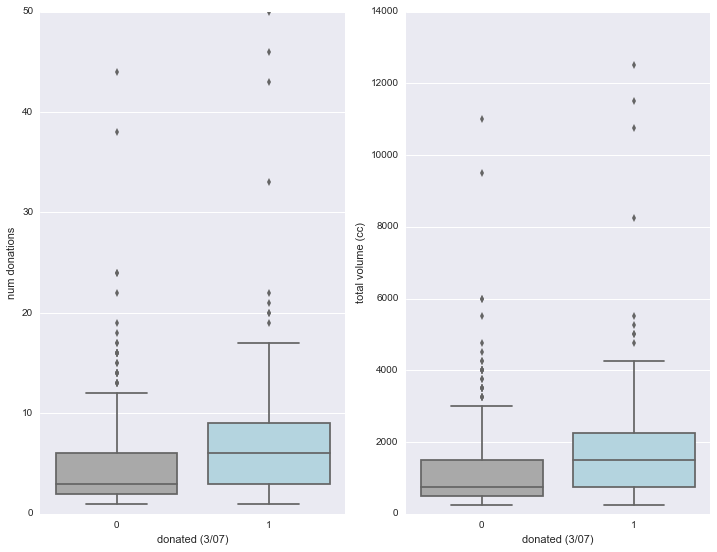

In [19]:
# Examine box plots for num donations and total volume (cc).
fig = plt.figure(figsize=(12,9))
ax1 = fig.add_subplot(121)
ax2 = fig.add_subplot(122)
colors = {0:'darkgray', 1:'lightblue'}
sns.boxplot('donated (3/07)', 'num donations', data=train, ax=ax1, palette=colors)
sns.boxplot('donated (3/07)', 'total volume (cc)', data=train, ax=ax2, palette=colors)

For both `num donations` and `total volume (cc)`, non-donators are more tightly distributed around lower values, while donators tend to have higher values in general and tend to be a bit more widely distributed. This aligns intuitively with the fact that we should expect donators to, in general, give more blood and donate more frequently.

#### Probability Plots ####

We want to check to see whether our features are normally distributed. We can do this using a probability plot, which is a visual representations of whether a given set of data follows a particular distribution (a normal distribution, in this case).

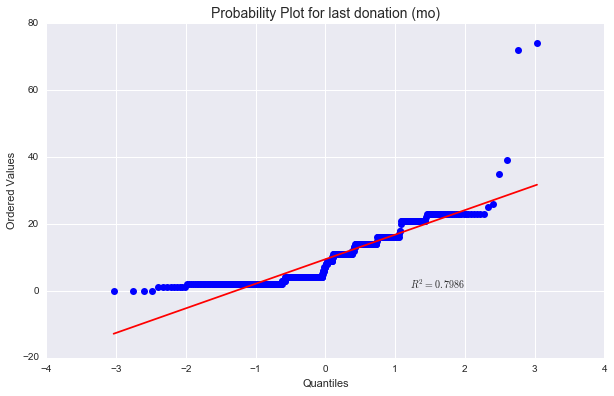

In [20]:
# Examine probability plot for last donation (mo).
fig = plt.figure(figsize=(10,6))
ax1 = fig.add_subplot(111)
ax1 = stats.probplot(train['last donation (mo)'], dist='norm', plot=ax1)
plt.title('Probability Plot for last donation (mo)', size=14)

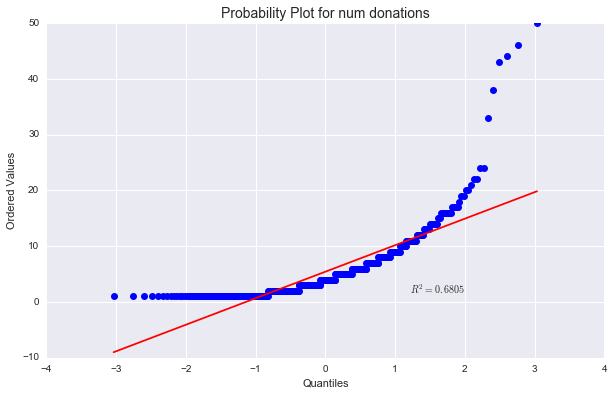

In [21]:
# Examine probability plot for num donations.
fig = plt.figure(figsize=(10,6))
ax1 = fig.add_subplot(111)
ax1 = stats.probplot(train['num donations'], dist='norm', plot=ax1)
plt.title('Probability Plot for num donations', size=14)

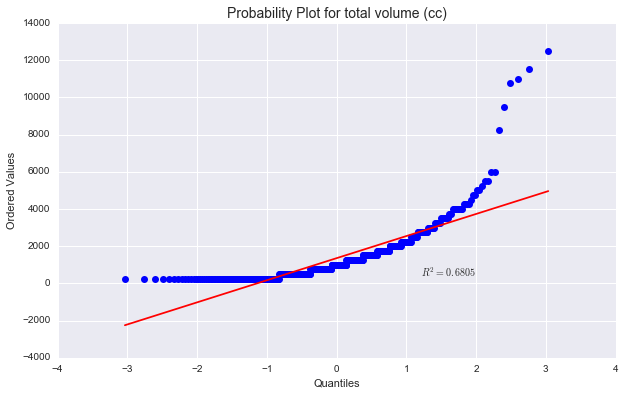

In [22]:
# Examine probability plot for total volume (cc).
fig = plt.figure(figsize=(10,6))
ax1 = fig.add_subplot(111)
ax1 = stats.probplot(train['total volume (cc)'], dist='norm', plot=ax1)
plt.title('Probability Plot for total volume (cc)', size=14)

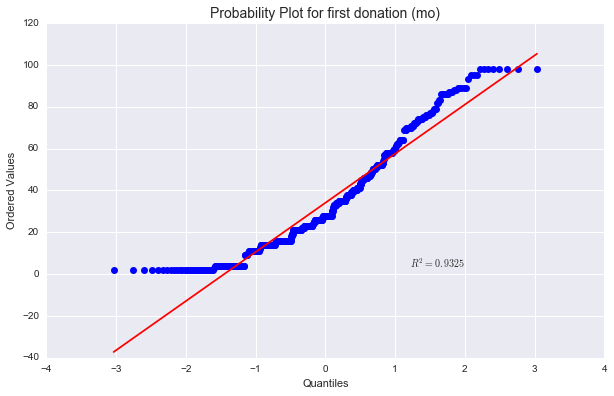

In [23]:
# Examine probability plot for first donation (mo).
fig = plt.figure(figsize=(10,6))
ax1 = fig.add_subplot(111)
ax1 = stats.probplot(train['first donation (mo)'], dist='norm', plot=ax1)
plt.title('Probability Plot for first donation (mo)', size=14)

We can also calculate skew to numerically test for normality.

In [24]:
# Check skew factors.
print('Skew factor for last donation (mo): %0.2f' % skew(train['last donation (mo)']))
print('Skew factor for num donations (mo): %0.2f' % skew(train['num donations']))
print('Skew factor for total volume (cc): %0.2f' % skew(train['total volume (cc)']))
print('Skew factor for first donation (mo): %0.2f' % skew(train['first donation (mo)']))

Skew factor for last donation (mo): 2.07
Skew factor for num donations (mo): 3.49
Skew factor for total volume (cc): 3.49
Skew factor for first donation (mo): 0.77


`last donation (mo)` and `first donation (mo)` look pretty good (i.e., follow the normal line pretty closely), with the exception of a few possible outliers. 0.77 is a reasonable skew factor (for `first donation (mo)`) so we'll leave that data alone, but let's see if we can improve the skew factor for `last donation (mo)` by removing the two outliers above `60`.

In [25]:
# Remove outliers.
print(train.shape)
train = train[train['last donation (mo)'] <= 60]
print(train.shape)

(576, 5)
(574, 5)


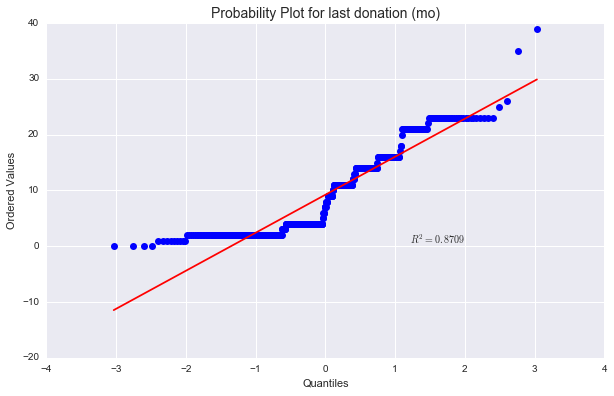

In [26]:
# Look at the updated probability plot for last donation (mo).
fig = plt.figure(figsize=(10,6))
ax1 = fig.add_subplot(111)
ax1 = stats.probplot(train['last donation (mo)'], dist='norm', plot=ax1)
plt.title('Probability Plot for last donation (mo)', size=14)

In [27]:
# Check updated skew factor.
print('Skew factor for last donation (mo) was: 2.07')
print('Skew factor for last donation (mo) is now: %0.2f' % skew(train['last donation (mo)']))

Skew factor for last donation (mo) was: 2.07
Skew factor for last donation (mo) is now: 0.70


Just removing those outliers changed our skew factor from `2.07` to `0.70`, which is a significant improvement.

Going back to our other skew factors, `num donations` and `total volumn (cc)` don't appear to be quite as normally distributed as our other two features. It's likely that we will discard one of these variables in our final model (since they are perfectly correlated). For the other, we might consider trying to normalize the data using a `log` or `boxcox` transformation.

In [28]:
# Skew factors for num donations (mo) and total volume (cc).
print('Skew factor for num donations: %0.2f' % skew(train['num donations']))
print('Skew factor for total volume (cc): %0.2f' % skew(train['total volume (cc)']))

Skew factor for num donations: 3.49
Skew factor for total volume (cc): 3.49


Let's see if we can normalize `num donations` in order to improve our skew factor. We'll compare `log` and `boxcox` transformations to see which yields the better results.

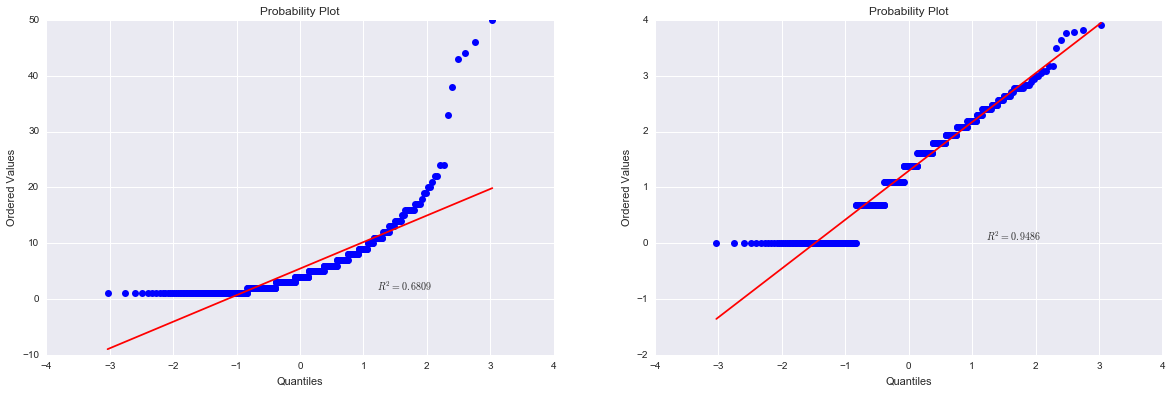

In [29]:
# Log transformation of num donations.
fig = plt.figure(figsize=(20,6))
ax1 = fig.add_subplot(121)
ax2 = fig.add_subplot(122)
ax1 = stats.probplot(train['num donations'], dist='norm', plot=ax1)
ax2 = stats.probplot(np.log(train['num donations']), dist='norm', plot=ax2)

# Note: having trouble labeling individual Axes instances. Tried ax1.set_title('') and got 'tuple' object has
# no attribute 'set_title'

In [30]:
# Compare skew factors.
print('Skew factor for original num donations: %0.2f' % skew(train['num donations']))
print('Skew factor for log transformed num donations: %0.2f' % skew(np.log(train['num donations'])))

Skew factor for original num donations: 3.49
Skew factor for log transformed num donations: 0.10


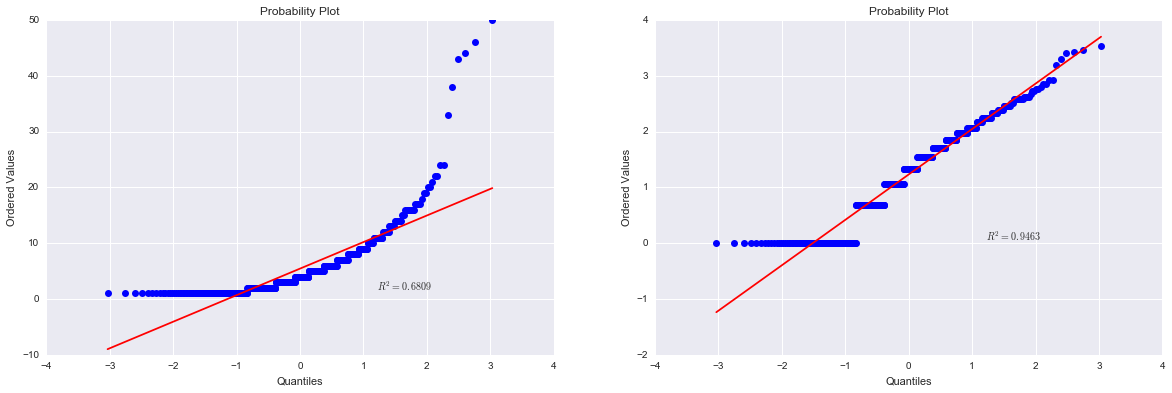

In [31]:
# Boxcox transformation of num donations.
boxcox_donations = stats.boxcox(train['num donations'].values)[0]
fig = plt.figure(figsize=(20,6))
ax1 = fig.add_subplot(121)
ax2 = fig.add_subplot(122)
ax1 = stats.probplot(train['num donations'], dist='norm', plot=ax1)
ax2 = stats.probplot(boxcox_donations, dist='norm', plot=ax2)

In [32]:
# Compare skew factors.
print('Skew factor for original num donations: %0.2f' % skew(train['num donations']))
print('Skew factor for boxcox transformed num donations: %0.2f' % skew(boxcox_donations))

Skew factor for original num donations: 3.49
Skew factor for boxcox transformed num donations: 0.01


`boxcox` offers a very significant improvement (even moreso than `log`), so we will use this normalized data in our training set.

In [33]:
# Use boxcox transformed num donations values in training set.
train_normal = train.copy()
train_normal['num donations'] = boxcox_donations

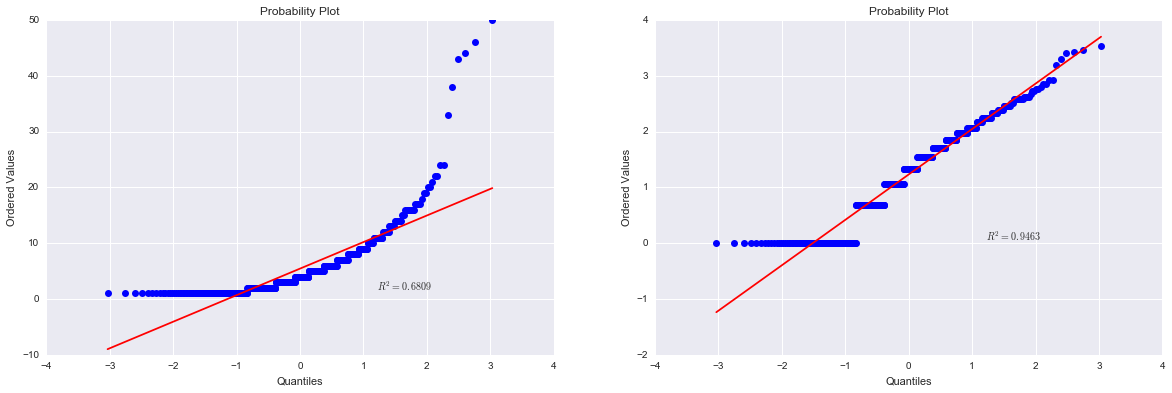

In [34]:
# Ensure new DataFrame contains the correct normalized values.
fig = plt.figure(figsize=(20,6))
ax1 = fig.add_subplot(121)
ax2 = fig.add_subplot(122)
ax1 = stats.probplot(train['num donations'], dist='norm', plot=ax1)
ax2 = stats.probplot(train_normal['num donations'], dist='norm', plot=ax2)

Even though we likely won't use `total volume (cc)` in our model, let's normalize it as well just in case we want to examine it further.

In [35]:
# Use boxcox transformed total volume (cc) values in training set.
boxcox_volume = stats.boxcox(train['total volume (cc)'].values)[0]
train_normal['total volume (cc)'] = boxcox_donations

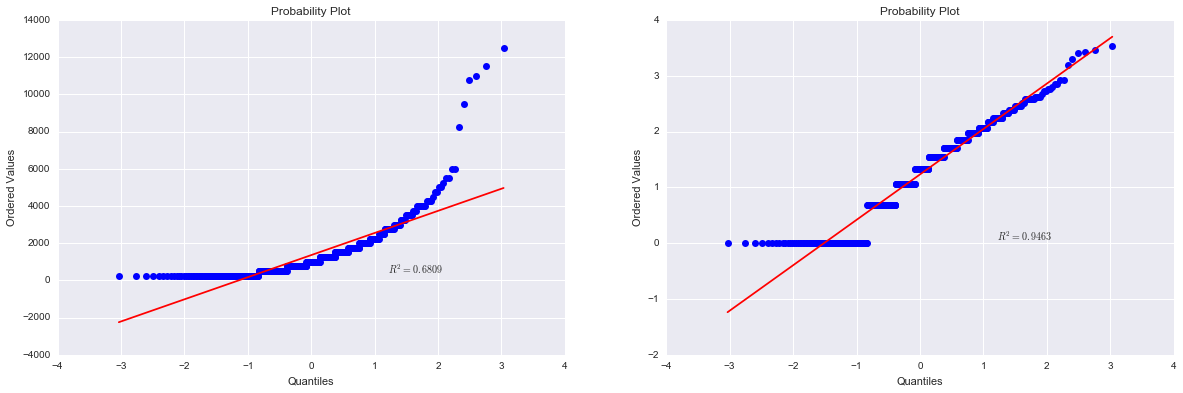

In [36]:
# Ensure new DataFrame contains the correct normalized values.
fig = plt.figure(figsize=(20,6))
ax1 = fig.add_subplot(121)
ax2 = fig.add_subplot(122)
ax1 = stats.probplot(train['total volume (cc)'], dist='norm', plot=ax1)
ax2 = stats.probplot(train_normal['total volume (cc)'], dist='norm', plot=ax2)

As with `num donations`, our skew is drastically improved.

In [37]:
# Compare skew factors.
print('Skew factor for original total volume (cc): %0.2f' % skew(train['total volume (cc)']))
print('Skew factor for boxcox transformed total volume (cc): %0.2f' % skew(boxcox_volume))

Skew factor for original total volume (cc): 3.49
Skew factor for boxcox transformed total volume (cc): 0.01


### Further Data Exploration ###

Next, we'll try to get a better understanding of the relationships between different features and between features and our outcome variable.

#### Correlation ####

In [38]:
# Examine correlation matrix again.
train_normal.corr()

,last donation (mo),num donations,total volume (cc),first donation (mo),donated (3/07)
last donation (mo),1.000000,-0.194085,-0.194085,0.162013,-0.277121
num donations,-0.194085,1.000000,1.000000,0.697634,0.238736
total volume (cc),-0.194085,1.000000,1.000000,0.697634,0.238736
first donation (mo),0.162013,0.697634,0.697634,1.000000,-0.016757
donated (3/07),-0.277121,0.238736,0.238736,-0.016757,1.000000


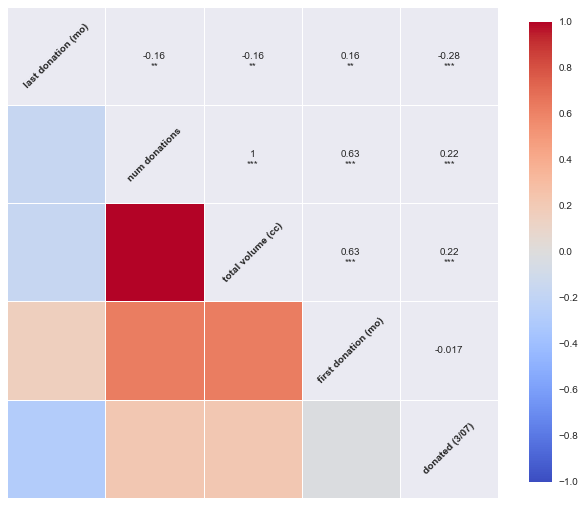

In [39]:
# Examine correlation plot for a visual representation of correlation.
fig = plt.figure(figsize=(11,11))
ax1 = plt.subplot(111)
sns.corrplot(train, ax=ax1)

As we saw above, we have multicollinearity between `num donations` and `total volume (cc)` so we should remove one of these features in our final model.

Our ultimate question is whether correlation in this dataset implies causation. For instance, because `num donations` is positively correlated with whether or not a person donated in March of 2007, does this imply that a greater number of previous donations *caused* the donation?

In order to interpret our eventual regression coefficients as causal with respect to the outcome, we need a) the assumptions of linear regression to hold (linearity, normality, independence, and homoskedasticity), and b) all possible confounders of the relationship of our features to the outcome to be present in the model (i.e., we need to avoid omitted variable bias).

While it is true that `num donations`, for example, is correlated with `donated (3/07)`, it is possible that there is a confounding factor such as blood type (perhaps having a universal blood type might cause someone to donate more often) or whether or not the person is a medical professional (being in a medical field might cause someone to donate more often out of a sense of duty to the profession).

Given these potential hidden variables, and the fact that we can likely come up with similar confounders for our other factors, it is unlikely that we can say we have perfectly causal relationships in our dataset.

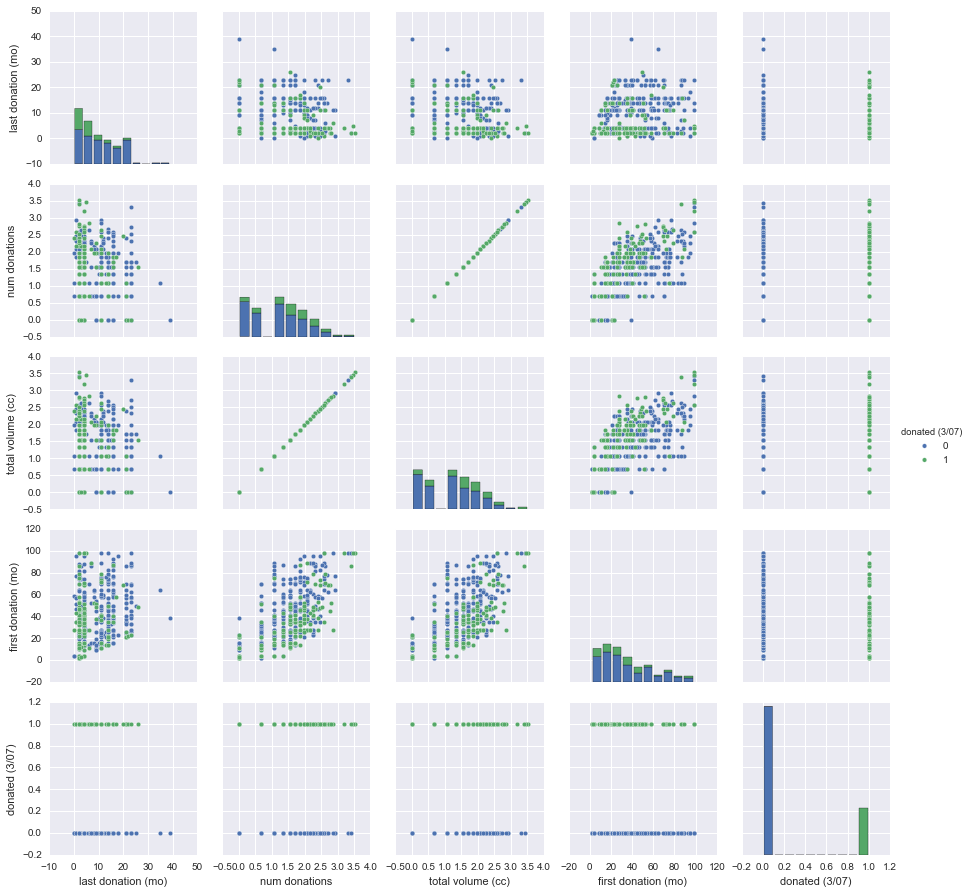

In [40]:
# Examine pair plot.
sns.pairplot(train_normal, hue='donated (3/07)')

Taking a look at individual scatter plots helps us see that there are other likely correlations among features (such as `num donations` and `first donation (mo)`). We will remove one of the perfectly correlated features (`num donations` and `total volume (cc)`), but even having features that are strongly (if not perfectly) correlated, might violate our independence assumption and contribute to our lack of certainty about causality.

### Linear Modeling ###

We will now see if we can find a suitable linear model. Since our outcome variable is binary, there is a good chance we won't have success with a linear model and should instead use a logistic regression model. But, as an exercise, we will see how well we can get a linear model to perform.

Again, the assumptions that must hold for a linear model to perform well are:

* Linear relationship between the factors and outcome variable
* Indepdence between factors (i.e., no multicollinearity)
* Normality of the error distribution
* Homoskedasticity of the errors

We will explore these assumptions as we try various models.

First, let's normalize our data and prepare it for regression. We will use the `sklearn.linear_model.LinearRegression()` implementation first to get a sense of where we stand. For now, we'll keep all the factors.

In [41]:
# First, boxcox transform num donations and total volume (cc) for test data to align the datasets.
test_normal = test.copy()
boxcox_donations_test = stats.boxcox(test['num donations'].values)[0]
test_normal['num donations'] = boxcox_donations_test
boxcox_volume_test = stats.boxcox(test['total volume (cc)'].values)[0]
test_normal['total volume (cc)'] = boxcox_volume_test

In [42]:
# Normalize training and test data and prepare X and y arrays to feed to the regression model.
minmax_scale1 = preprocessing.MinMaxScaler().fit(train_normal[['last donation (mo)', 'num donations',
                                                             'total volume (cc)', 'first donation (mo)']])
X_train1 = minmax_scale1.transform(train_normal[['last donation (mo)', 'num donations',
                                                             'total volume (cc)', 'first donation (mo)']])
y_train1 = train_normal['donated (3/07)'].values
X_test1 = minmax_scale1.transform(test_normal)

In [43]:
# Fit the model on the data.
regr1 = linear_model.LinearRegression()
regr1.fit(X_train1, y_train1)
y_hat1 = regr1.predict(X_train1)
residual1 = y_train1 - y_hat1
y_hat_test1 = regr1.predict(X_test1)
print('R-squared: %0.4f' % regr1.score(X_train1, y_train1))
print('Mean Squared Error: %0.4f' % mean_squared_error(y_train1, y_hat1))
print('Coefficients: %s' % regr1.coef_)
print('Intercept: %0.4f' % regr1.intercept_)
result1 = pd.DataFrame()
result1['Prediction'] = y_hat_test1
result1.set_index(test_normal.index, inplace=True)
result1.head()

R-squared: 0.1421
Mean Squared Error: 0.1567
Coefficients: [-0.36159029  0.35621167  0.35621167 -0.45163246]
Intercept: 0.2272


,Prediction
659,0.783652
276,0.600399
263,0.624534
303,0.754522
83,0.849790


In [44]:
# Look at distribution of predictions.
result1.describe()

,Prediction
count,200.000000
mean,0.624079
std,0.141736
min,0.121397
25%,0.549921
50%,0.625406
75%,0.732424
max,0.893676


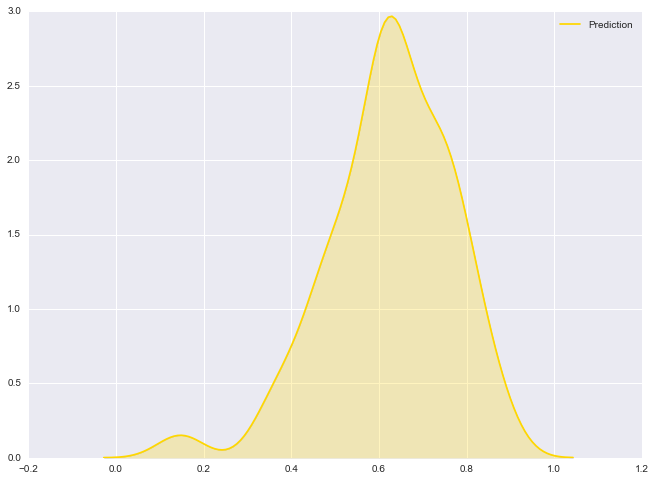

In [45]:
# Visual representation of predictions distribution.
fig = plt.figure(figsize=(11,8))
ax1 = fig.add_subplot(111)
sns.kdeplot(result1['Prediction'], ax=ax1, shade=True, color='gold')

Our R-squared value is very low, indicating that a very low percentage of the variation in our outcome variable is explained by the model. This indicates a poor fit. However, our predictions do fall pretty nicely within the 0 to 1 range that we're looking for.

We can take a look at some of the residual plots to get a sense of what the errors look like.

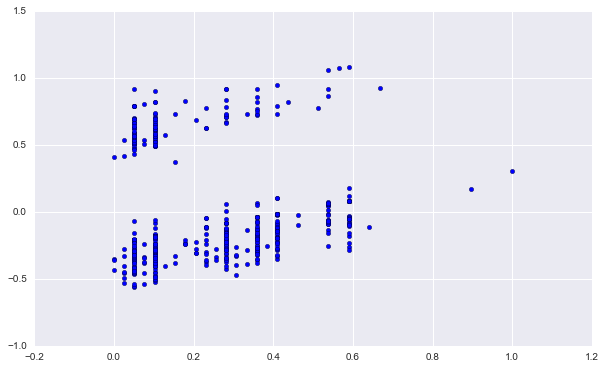

In [46]:
# Check residual plot for last donation (mo).
fig = plt.figure(figsize=(10,6))
ax1 = fig.add_subplot(111)
ax1.scatter(X_train1[:,0], residual1)

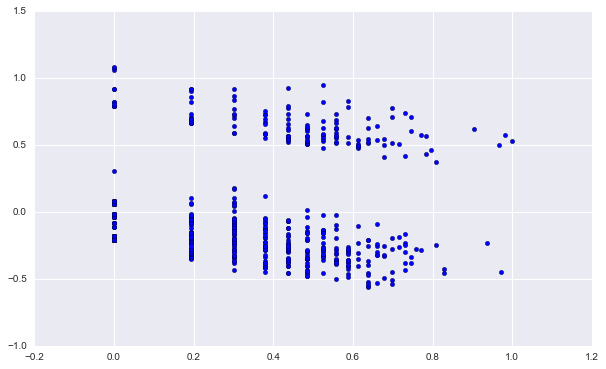

In [47]:
# Check residual plot for num donations.
fig = plt.figure(figsize=(10,6))
ax1 = fig.add_subplot(111)
ax1.scatter(X_train1[:,1], residual1)

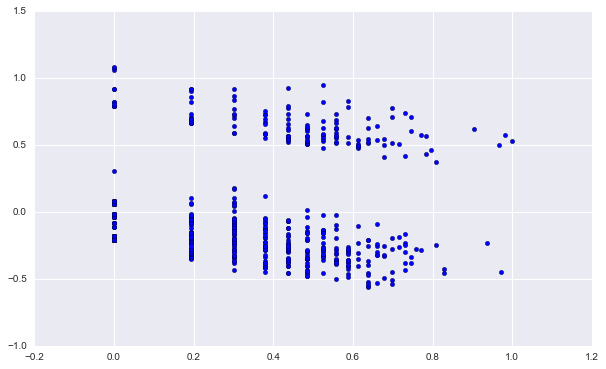

In [48]:
# Check residual plot for total volume (cc).
fig = plt.figure(figsize=(10,6))
ax1 = fig.add_subplot(111)
ax1.scatter(X_train1[:,2], residual1)

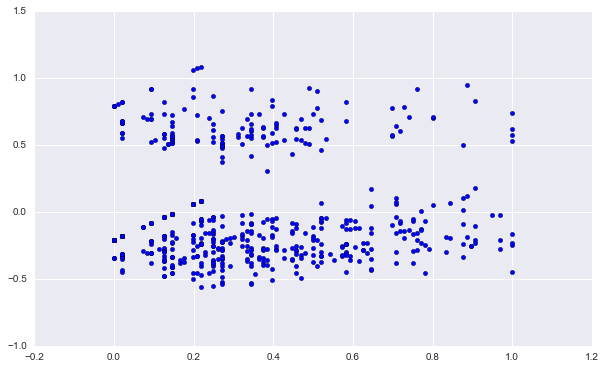

In [49]:
# Check residual plot for first donation (mo).
fig = plt.figure(figsize=(10,6))
ax1 = fig.add_subplot(111)
ax1.scatter(X_train1[:,3], residual1)

`first donation (mo)` appears to have the residual plot that is most normally distributed (points scattered relatively randomly above and below the `0`-line) and doesn't appear to have much homoskedasticity.

The other residual plots, however, don't appear to be incredibly normally distributed.

Next, let's see what happens to our model when we remove one of the collinear variables. Let's remove `total volume (cc)`.

In [50]:
# Normalize data and create new X and y to feed to the model.
minmax_scale2 = preprocessing.MinMaxScaler().fit(train_normal[['last donation (mo)', 'num donations',
                                                             'first donation (mo)']])
X_train2 = minmax_scale2.transform(train_normal[['last donation (mo)', 'num donations', 
                                               'first donation (mo)']])
y_train2 = train_normal['donated (3/07)'].values
X_test2 = minmax_scale2.transform(test_normal[['last donation (mo)', 'num donations', 
                                               'first donation (mo)']])

In [51]:
# Fit the model on the data.
regr2 = linear_model.LinearRegression()
regr2.fit(X_train2, y_train2)
y_hat2 = regr2.predict(X_train2)
residual2 = y_train2 - y_hat2
y_hat_test2 = regr2.predict(X_test2)
print('R-squared: %0.4f' % regr2.score(X_train2, y_train2))
print('Mean Squared Error: %0.4f' % mean_squared_error(y_train2, y_hat2))
print('Coefficients: %s' % regr2.coef_)
print('Intercept: %0.4f' % regr2.intercept_)
result2 = pd.DataFrame()
result2['Prediction'] = y_hat_test2
result2.set_index(test_normal.index, inplace=True)
result2.head()

R-squared: 0.1421
Mean Squared Error: 0.1567
Coefficients: [-0.36159029  0.71242335 -0.45163246]
Intercept: 0.2272


,Prediction
659,0.425290
276,0.225021
263,0.180716
303,0.393466
83,0.491428


In [52]:
# Look at distribution of predictions.
result2.describe()

,Prediction
count,200.000000
mean,0.226573
std,0.160547
min,-0.322422
25%,0.134745
50%,0.218246
75%,0.338563
max,0.552165


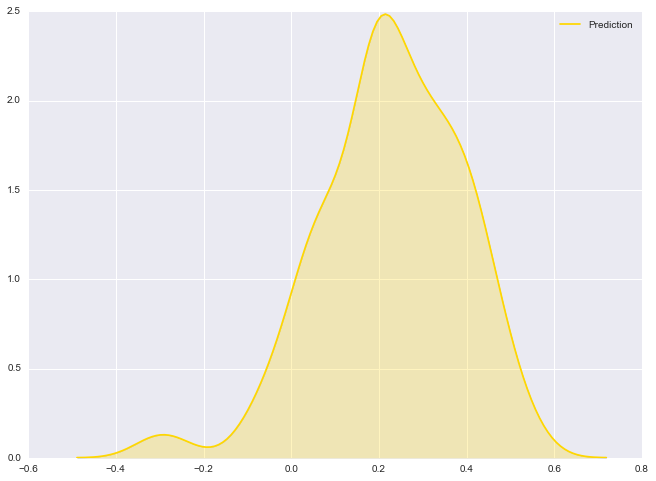

In [53]:
# Visual representation of predictions distribution.
fig = plt.figure(figsize=(11,8))
ax1 = fig.add_subplot(111)
sns.kdeplot(result2['Prediction'], ax=ax1, shade=True, color='gold')

Our R-squared and MSE are unchanged, so this does not appear to have improved our model. Our predictions are also extending slightly past 0 into negative territory and don't get as close to 1 as in our last model.

Let's check the residuals again.

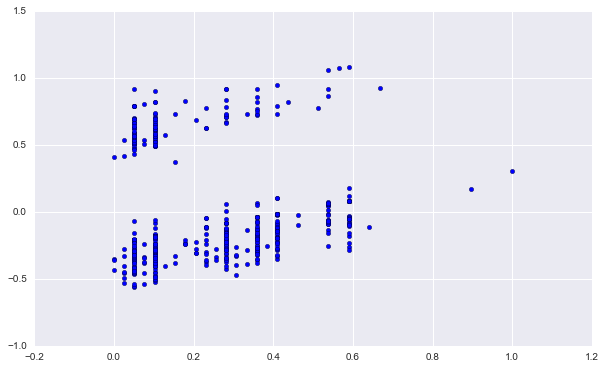

In [54]:
# Check residual plot for last donation (mo).
fig = plt.figure(figsize=(10,6))
ax1 = fig.add_subplot(111)
ax1.scatter(X_train2[:,0], residual2)

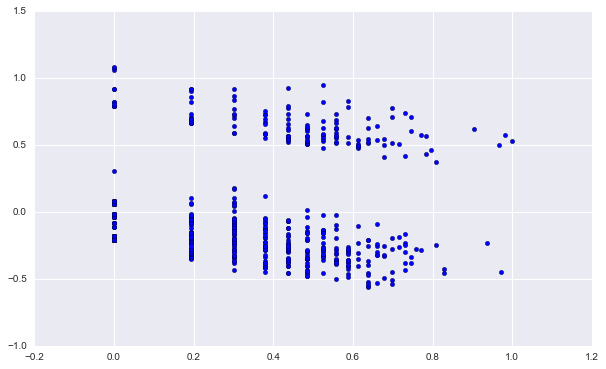

In [55]:
# Check residual plot for num donations.
fig = plt.figure(figsize=(10,6))
ax1 = fig.add_subplot(111)
ax1.scatter(X_train2[:,1], residual2)

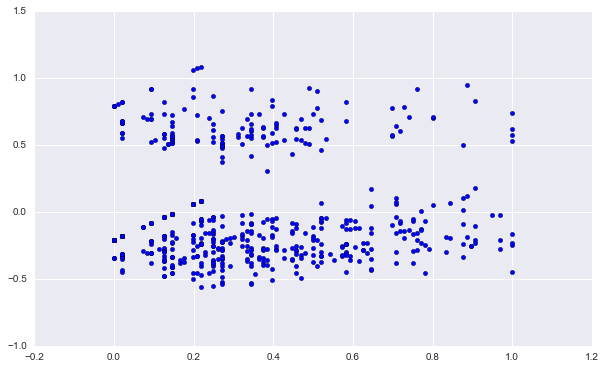

In [56]:
# Check residual plot for first donation (mo).
fig = plt.figure(figsize=(10,6))
ax1 = fig.add_subplot(111)
ax1.scatter(X_train2[:,2], residual2)

The residuals look more or less unchanged.

Now, let's use the `statsmodels OLS` linear regression implementation so we can drill down into some of the metrics in further detail.

In [57]:
# Build a normalized training DataFrame that will be easier to use with statsmodels OLS than lists.
minmax_scale3 = preprocessing.MinMaxScaler().fit(train_normal[['last donation (mo)', 'num donations',
                                                             'total volume (cc)', 'first donation (mo)']])
X_train3 = minmax_scale3.transform(train_normal[['last donation (mo)', 'num donations',
                                                             'total volume (cc)', 'first donation (mo)']])
X_test3 = minmax_scale3.transform(test_normal)
train_df = pd.DataFrame()
train_df['last donation (mo)'] = X_train3[:,0]
train_df['num donations'] = X_train3[:,1]
train_df['total volume (cc)'] = X_train3[:,2]
train_df['first donation (mo)'] = X_train3[:,3]
train_df['donated (3/07)'] = train_normal['donated (3/07)'].values
test_df = pd.DataFrame()
test_df['last donation (mo)'] = X_test3[:,0]
test_df['num donations'] = X_test3[:,1]
test_df['total volume (cc)'] = X_test3[:,2]
test_df['first donation (mo)'] = X_test3[:,3]

In [58]:
# Fit the model on the data.
data_for_regr = train_df.copy()
data_for_regr['ones'] = np.ones(len(data_for_regr))
y_trn1 = data_for_regr['donated (3/07)']
X_trn1 = data_for_regr[['last donation (mo)', 'num donations', 'total volume (cc)', 'first donation (mo)']]
X_tst1 = test_df.copy()
lm1 = sm.OLS(y_trn1, X_trn1).fit()
predict1 = pd.DataFrame()
predict1['Prediction'] = lm1.predict(X_tst1)
predict1.set_index(test_normal.index, inplace=True)
predict1.head()

,Prediction
659,0.942530
276,0.913388
263,0.655048
303,1.003294
83,1.040884


In [59]:
# Look at the summary metrics.
lm1.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:         donated (3/07)   R-squared:                       0.311
Model:                            OLS   Adj. R-squared:                  0.308
Method:                 Least Squares   F-statistic:                     86.02
Date:                Thu, 21 Jul 2016   Prob (F-statistic):           6.21e-46
Time:                        17:07:30   Log-Likelihood:                -298.37
No. Observations:                 574   AIC:                             602.7
Df Residuals:                     571   BIC:                             615.8
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
=======================================================================================
                          coef    std err          t      P>|t|      [95.0% Conf. Int.]
---------------------------------------------------------------------------------------
last donation (mo)      0.0082      0.078      0.105      0.916        -0.145     0.162
num donations           0.5338      0.046     11.652      0.000         0.444     0.624
total volume (cc)       0.5338      0.046     11.652      0.000         0.444     0.624
first donation (mo)    -0.5223      0.104     -5.044      0.000        -0.726    -0.319
==============================================================================
Omnibus:                       60.992   Durbin-Watson:                   1.727
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               77.231
Skew:                           0.885   Prob(JB):                     1.70e-17
Kurtosis:                       2.691   Cond. No.                     1.29e+16
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The smallest eigenvalue is 1.89e-30. This might indicate that there are
strong multicollinearity problems or that the design matrix is singular.
"""

With all our factors included, our R-squared is slightly better on this implementation.

#### Hypothesis Testing ####

Let's take a look at the p-values from the summary above. The p-value for each feature's coefficient is the result of the following hypothesis test:

* $H_0$: The feature in question has no effect on the outcome variable.
* $H_\alpha$: The feature in question *does* have an effect on the outcome variable.

The p-value is a measure of how well our sample data supports the null hypothesis. It can be interpreted as the probability of getting the data we did, given that the feature in question does not effect the outcome variable.

So, for low p-values, there is a low probability of getting the data we have if the feature has no effect on the outcome (from which we can reasonably say that the feature must have an effect on the outcome), and for high p-values, there is a very good chance we would get the data we have if the feature has no effect on the outcome (from which we can say that the feature probably does not have a significant effect on the outcome).

Above, our summary metrics suggest that `last donation (mo)` has very little effect on whether a person donated, while the other three features do have a significant effect. We will likely want to try a model that does not include `last donation (mo)`, which we will do later on.

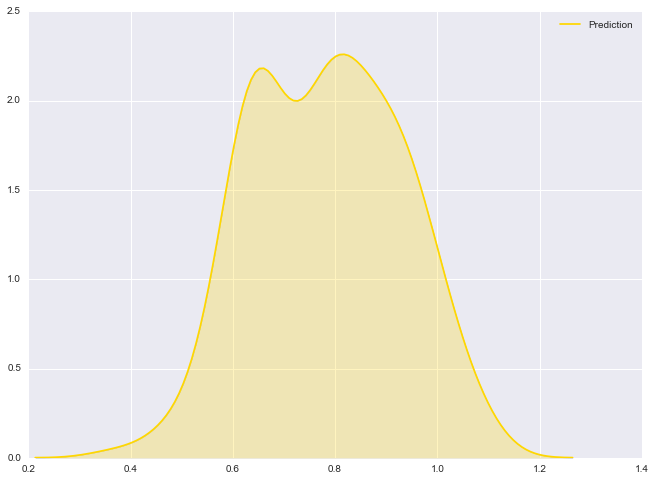

In [60]:
# Visual representation of predictions distribution.
fig = plt.figure(figsize=(11,8))
ax1 = fig.add_subplot(111)
sns.kdeplot(predict1['Prediction'], ax=ax1, shade=True, color='gold')

Our predictions look to be shifted a bit higher in general under this implementation of our four-feature model.

Let's look again at the residuals.

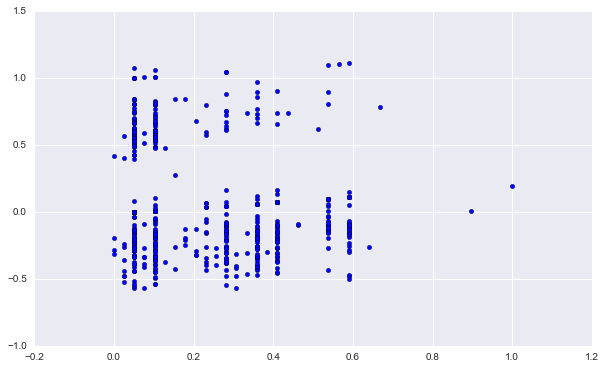

In [62]:
# Check residual plot for last donation (mo).
residue1 = lm1.resid
fig = plt.figure(figsize=(10,6))
ax1 = fig.add_subplot(111)
ax1.scatter(X_trn1['last donation (mo)'], residue1.values)

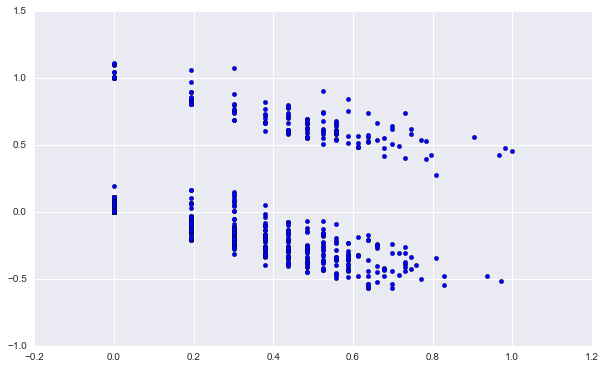

In [63]:
# Check residual plot for num donations.
residue1 = lm1.resid
fig = plt.figure(figsize=(10,6))
ax1 = fig.add_subplot(111)
ax1.scatter(X_trn1['num donations'], residue1.values)

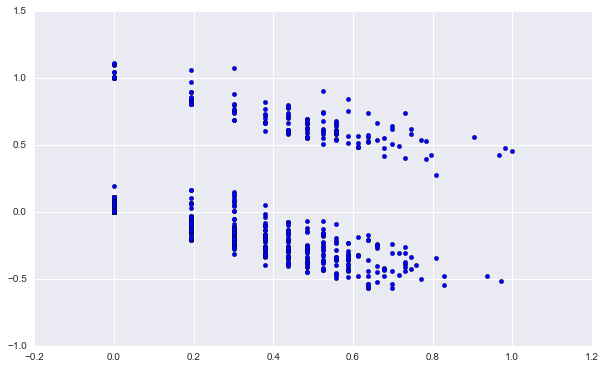

In [64]:
# Check residual plot for total volume (cc).
residue1 = lm1.resid
fig = plt.figure(figsize=(10,6))
ax1 = fig.add_subplot(111)
ax1.scatter(X_trn1['total volume (cc)'], residue1.values)

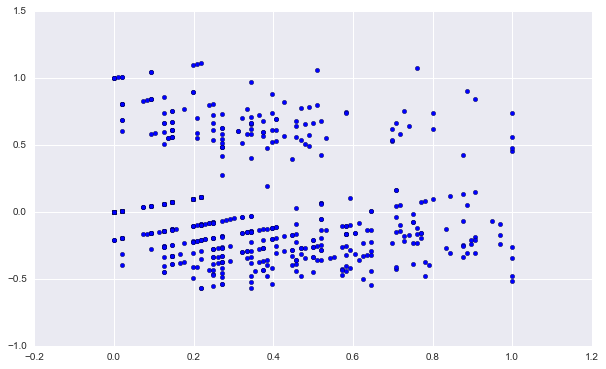

In [65]:
# Check residual plot for first donation (mo).
residue1 = lm1.resid
fig = plt.figure(figsize=(10,6))
ax1 = fig.add_subplot(111)
ax1.scatter(X_trn1['first donation (mo)'], residue1.values)

`last donation (mo)` looks slightly better on this implementation and `first donation (mo)` still looks pretty decent.

Let's drop `total volume (cc)` again.

In [67]:
# Fit the model on the data.
data_for_regr = train_df.copy()
test_data = test_df.copy()
data_for_regr['ones'] = np.ones(len(data_for_regr))
y_trn2 = data_for_regr['donated (3/07)']
X_trn2 = data_for_regr[['last donation (mo)', 'num donations', 'first donation (mo)']]
X_tst2 = test_data[['last donation (mo)', 'num donations', 'first donation (mo)']]
lm2 = sm.OLS(y_trn2, X_trn2).fit()
predict2 = pd.DataFrame()
predict2['Prediction'] = lm2.predict(X_tst2)
predict2.set_index(test_normal.index, inplace=True)
predict2.head()

,Prediction
659,0.405508
276,0.350866
263,-0.010035
303,0.462235
83,0.503861


In [68]:
# Look at the summary metrics.
lm2.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:         donated (3/07)   R-squared:                       0.311
Model:                            OLS   Adj. R-squared:                  0.308
Method:                 Least Squares   F-statistic:                     86.02
Date:                Thu, 21 Jul 2016   Prob (F-statistic):           6.21e-46
Time:                        17:11:07   Log-Likelihood:                -298.37
No. Observations:                 574   AIC:                             602.7
Df Residuals:                     571   BIC:                             615.8
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
=======================================================================================
                          coef    std err          t      P>|t|      [95.0% Conf. Int.]
---------------------------------------------------------------------------------------
last donation (mo)      0.0082      0.078      0.105      0.916        -0.145     0.162
num donations           1.0676      0.092     11.652      0.000         0.888     1.248
first donation (mo)    -0.5223      0.104     -5.044      0.000        -0.726    -0.319
==============================================================================
Omnibus:                       60.992   Durbin-Watson:                   1.727
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               77.231
Skew:                           0.885   Prob(JB):                     1.70e-17
Kurtosis:                       2.691   Cond. No.                         4.91
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

Our R-squared and Adjusted-R-squared haven't changed, and the p-value for `last donation (mo)` is still showing that this factor has no significant effect on our outcome variable.

Next, let's try taking `last donation (mo)` out of the model and just using the remaining two.

In [69]:
# Fit the model on the data.
data_for_regr = train_df.copy()
test_data = test_df.copy()
data_for_regr['ones'] = np.ones(len(data_for_regr))
y_trn3 = data_for_regr['donated (3/07)']
X_trn3 = data_for_regr[['num donations', 'first donation (mo)']]
X_tst3 = test_data[['num donations', 'first donation (mo)']]
lm3 = sm.OLS(y_trn3, X_trn3).fit()
predict3 = pd.DataFrame()
predict3['Prediction'] = lm3.predict(X_tst3)
predict3.set_index(test_normal.index, inplace=True)
predict3.head()

,Prediction
659,0.407058
276,0.347796
263,-0.010778
303,0.461176
83,0.504057


In [70]:
# Look at distribution of predictions.
predict3.describe()

,Prediction
count,200.000000
mean,0.186239
std,0.186202
min,-0.254576
25%,0.000000
50%,0.192695
75%,0.327351
max,0.594348


In [71]:
# Look at the summary metrics.
lm3.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:         donated (3/07)   R-squared:                       0.311
Model:                            OLS   Adj. R-squared:                  0.309
Method:                 Least Squares   F-statistic:                     129.2
Date:                Thu, 21 Jul 2016   Prob (F-statistic):           4.85e-47
Time:                        17:11:13   Log-Likelihood:                -298.37
No. Observations:                 574   AIC:                             600.7
Df Residuals:                     572   BIC:                             609.4
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
=======================================================================================
                          coef    std err          t      P>|t|      [95.0% Conf. Int.]
---------------------------------------------------------------------------------------
num donations           1.0666      0.091     11.711      0.000         0.888     1.246
first donation (mo)    -0.5173      0.092     -5.616      0.000        -0.698    -0.336
==============================================================================
Omnibus:                       60.780   Durbin-Watson:                   1.728
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               76.907
Skew:                           0.883   Prob(JB):                     1.99e-17
Kurtosis:                       2.692   Cond. No.                         4.28
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

Adjusted R-squared is up very slightly, indicating that we gained a very small amount of predictive power. However, we'll need to do a lot better!

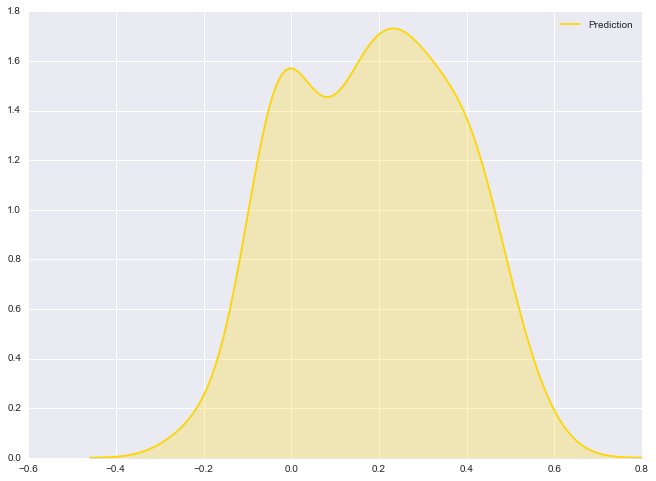

In [72]:
# Visual representation of predictions distribution.
fig = plt.figure(figsize=(11,8))
ax1 = fig.add_subplot(111)
sns.kdeplot(predict3['Prediction'], ax=ax1, shade=True, color='gold')

Let's try adding a new column to the data called `frequency` that is `first donation (mo)` divided by `num donations`. So, we'll get the number of months since the first donation divided by the total number of donations, giving us a metric of how many months typically pass between donations if they were evenly spread out. We'll set the frequency value for a `0` in the `num donations` to `0`, though this is a possible snag with this created feature. 

In [73]:
# Fit the model on the data.
data_for_regr = train_df.copy()
test_data = test_df.copy()
data_for_regr['ones'] = np.ones(len(data_for_regr))
y_trn4 = data_for_regr['donated (3/07)']
X_trn4 = data_for_regr[['num donations', 'first donation (mo)']]
X_tst4 = test_data[['num donations', 'first donation (mo)']]
X_trn4_fq = X_trn4.copy()
X_trn4_fq['frequency'] = (X_trn4_fq['first donation (mo)'])/(X_trn4_fq['num donations'])
X_trn4_fq.replace([np.inf, -np.inf], float(0), inplace=True)
X_trn4_fq.replace([np.nan], float(0), inplace=True)
X_tst4_fq = X_tst4.copy()
X_tst4_fq['frequency'] = (X_tst4_fq['first donation (mo)'])/(X_tst4_fq['num donations'])
X_tst4_fq.replace([np.inf, -np.inf], float(0), inplace=True)
X_tst4_fq.replace([np.nan], float(0), inplace=True)
lm4 = sm.OLS(y_trn4, X_trn4_fq).fit()
predict4 = pd.DataFrame()
predict4['Prediction'] = lm4.predict(X_tst4_fq)
predict4.set_index(test_normal.index, inplace=True)
predict4.head()

,Prediction
659,0.404120
276,0.348202
263,-0.011542
303,0.460294
83,0.503543


In [74]:
# Look at the summary metrics.
lm4.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:         donated (3/07)   R-squared:                       0.311
Model:                            OLS   Adj. R-squared:                  0.308
Method:                 Least Squares   F-statistic:                     86.08
Date:                Thu, 21 Jul 2016   Prob (F-statistic):           5.86e-46
Time:                        17:11:22   Log-Likelihood:                -298.31
No. Observations:                 574   AIC:                             602.6
Df Residuals:                     571   BIC:                             615.7
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
=======================================================================================
                          coef    std err          t      P>|t|      [95.0% Conf. Int.]
---------------------------------------------------------------------------------------
num donations           1.0726      0.093     11.574      0.000         0.891     1.255
first donation (mo)    -0.5540      0.138     -4.017      0.000        -0.825    -0.283
frequency               0.0151      0.042      0.358      0.721        -0.068     0.098
==============================================================================
Omnibus:                       61.314   Durbin-Watson:                   1.726
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               77.595
Skew:                           0.887   Prob(JB):                     1.41e-17
Kurtosis:                       2.684   Cond. No.                         10.1
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

Our model did not perform any better. This is probably a good thing, since it still might be problematic to consider `0` months elapsing between donations for those who never donate.

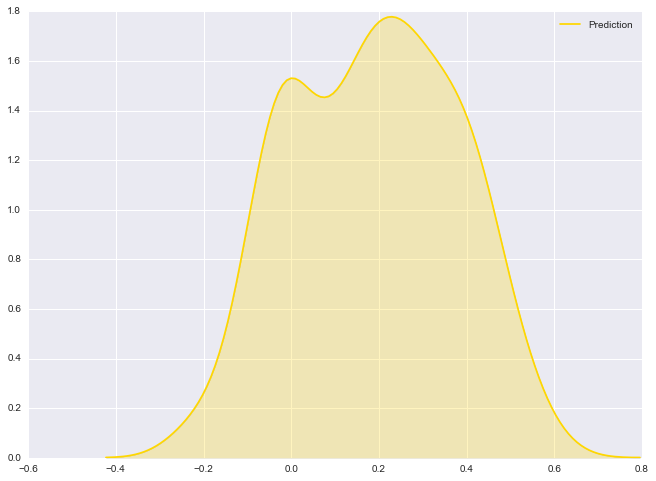

In [75]:
# Visual representation of predictions distribution.
fig = plt.figure(figsize=(11,8))
ax1 = fig.add_subplot(111)
sns.kdeplot(predict4['Prediction'], ax=ax1, shade=True, color='gold')

In [76]:
# Fit the model on the data.
data_for_regr = train_df.copy()
test_data = test_df.copy()
data_for_regr['ones'] = np.ones(len(data_for_regr))
poly2 = preprocessing.PolynomialFeatures(2)
y_trn5 = data_for_regr['donated (3/07)']
X_trn5 = data_for_regr[['num donations', 'first donation (mo)']]
X_trn5_poly = poly2.fit_transform(X_trn5)
X_tst5 = test_data[['num donations', 'first donation (mo)']]
X_tst5_poly = poly2.fit_transform(X_tst5)
lm5 = sm.OLS(y_trn5, X_trn5_poly).fit()
predict5 = pd.DataFrame()
predict5['Prediction'] = lm5.predict(X_tst5_poly)
predict5.set_index(test_normal.index, inplace=True)
predict5.head()

,Prediction
659,0.354859
276,0.310936
263,0.153494
303,0.472705
83,0.558982


In [77]:
# Look at the summary metrics.
lm5.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:         donated (3/07)   R-squared:                       0.141
Model:                            OLS   Adj. R-squared:                  0.134
Method:                 Least Squares   F-statistic:                     18.70
Date:                Thu, 21 Jul 2016   Prob (F-statistic):           3.16e-17
Time:                        17:11:26   Log-Likelihood:                -282.72
No. Observations:                 574   AIC:                             577.4
Df Residuals:                     568   BIC:                             603.6
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [95.0% Conf. Int.]
------------------------------------------------------------------------------
const          0.1692      0.041      4.177      0.000         0.090     0.249
x1             0.4825      0.249      1.938      0.053        -0.006     0.972
x2            -0.7768      0.271     -2.868      0.004        -1.309    -0.245
x3             1.5732      0.526      2.992      0.003         0.540     2.606
x4            -1.9363      0.704     -2.750      0.006        -3.319    -0.553
x5             1.0726      0.401      2.676      0.008         0.285     1.860
==============================================================================
Omnibus:                       70.546   Durbin-Watson:                   1.757
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               95.725
Skew:                           0.997   Prob(JB):                     1.64e-21
Kurtosis:                       2.827   Cond. No.                         62.6
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

This model alone does much worse than what we had, but the `x3` term (which is `num donations` squared) seems to have a pretty good p-value. What if we try this factor in our `lm3` model (which is our best performer, scorewise, so far)?

In [78]:
# First, get num donations squared.
X_trn5_poly_df = pd.DataFrame(X_trn5_poly)
num_donations_squared_train = X_trn5_poly_df[3].values
X_tst5_poly_df = pd.DataFrame(X_tst5_poly)
num_donations_squared_test = X_tst5_poly_df[3].values

In [79]:
# Fit the model on the data.
data_for_regr = train_df.copy()
test_data = test_df.copy()
data_for_regr['ones'] = np.ones(len(data_for_regr))
y_trn6 = data_for_regr['donated (3/07)']
X_trn6_poly_num = pd.DataFrame()
X_trn6_poly_num['num donations squared'] = num_donations_squared_train
X_trn6_poly_num['first donation (mo)'] = data_for_regr['first donation (mo)']
X_tst6_poly_num = pd.DataFrame()
X_tst6_poly_num['num donations squared'] = num_donations_squared_test
X_tst6_poly_num['first donation (mo)'] = test_data['first donation (mo)']
lm6 = sm.OLS(y_trn6, X_trn6_poly_num).fit()
predict6 = pd.DataFrame()
predict6['Prediction'] = lm6.predict(X_tst6_poly_num)
predict6.set_index(test_normal.index, inplace=True)
predict6.head()

,Prediction
659,0.399171
276,0.248375
263,-0.003896
303,0.395632
83,0.434238


In [80]:
# Look at the summary metrics.
lm6.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:         donated (3/07)   R-squared:                       0.251
Model:                            OLS   Adj. R-squared:                  0.248
Method:                 Least Squares   F-statistic:                     95.84
Date:                Thu, 21 Jul 2016   Prob (F-statistic):           1.27e-36
Time:                        17:11:33   Log-Likelihood:                -322.44
No. Observations:                 574   AIC:                             648.9
Df Residuals:                     572   BIC:                             657.6
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
=========================================================================================
                            coef    std err          t      P>|t|      [95.0% Conf. Int.]
-----------------------------------------------------------------------------------------
num donations squared     1.2345      0.138      8.949      0.000         0.964     1.505
first donation (mo)      -0.1870      0.083     -2.256      0.024        -0.350    -0.024
==============================================================================
Omnibus:                       59.167   Durbin-Watson:                   1.701
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               76.498
Skew:                           0.893   Prob(JB):                     2.45e-17
Kurtosis:                       2.894   Cond. No.                         4.17
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

This model performs worse than when we had the un-transformed values of `num donations`. With the addition of `num donations squared`, our p-value for `first donation (mo)` has gone up.

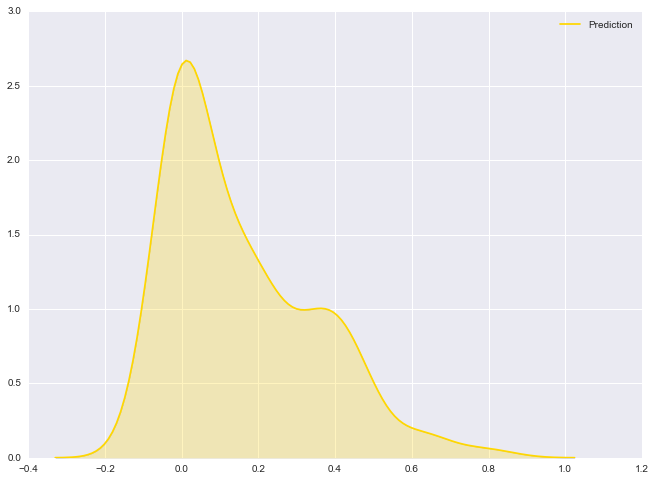

In [81]:
# Visual representation of predictions distribution.
fig = plt.figure(figsize=(11,8))
ax1 = fig.add_subplot(111)
sns.kdeplot(predict6['Prediction'], ax=ax1, shade=True, color='gold')

What do the residuals look like?

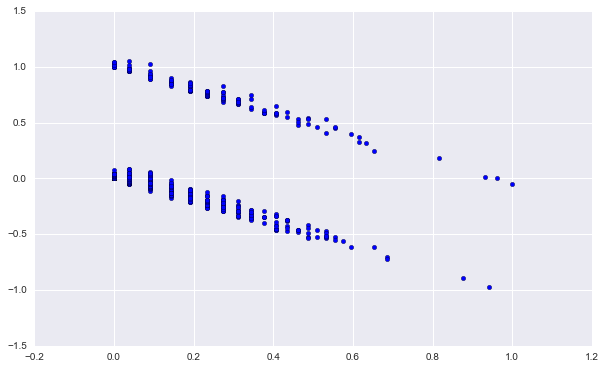

In [82]:
# Check residual plot for num donations squared.
residue6 = lm6.resid
fig = plt.figure(figsize=(10,6))
ax1 = fig.add_subplot(111)
ax1.scatter(X_trn6_poly_num['num donations squared'], residue6.values)

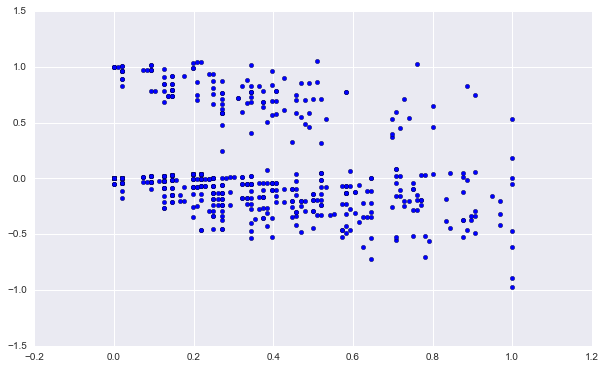

In [83]:
# Check residual plot for first donation (mo).
residue6 = lm6.resid
fig = plt.figure(figsize=(10,6))
ax1 = fig.add_subplot(111)
ax1.scatter(X_trn6_poly_num['first donation (mo)'], residue6.values)

The resididual for `num donations squared` looks much worse than it used to, so the polynomial transformation was not helpful.

What happens when we add `last donation (mo)` back in

In [84]:
# Fit the model on the data.
data_for_regr = train_df.copy()
test_data = test_df.copy()
data_for_regr['ones'] = np.ones(len(data_for_regr))
y_trn7 = data_for_regr['donated (3/07)']
X_trn7_poly_num = pd.DataFrame()
X_trn7_poly_num['last donation (mo)'] = data_for_regr['last donation (mo)']
X_trn7_poly_num['num donations squared'] = num_donations_squared_train
X_trn7_poly_num['first donation (mo)'] = data_for_regr['first donation (mo)']
X_tst7_poly_num = pd.DataFrame()
X_tst7_poly_num['last donation (mo)'] = test_data['last donation (mo)']
X_tst7_poly_num['num donations squared'] = num_donations_squared_test
X_tst7_poly_num['first donation (mo)'] = test_data['first donation (mo)']
lm7 = sm.OLS(y_trn7, X_trn7_poly_num).fit()
predict7 = pd.DataFrame()
predict7['Prediction'] = lm7.predict(X_tst7_poly_num)
predict7.set_index(test_normal.index, inplace=True)
predict7.head()

,Prediction
659,0.378571
276,0.305697
263,0.008997
303,0.423917
83,0.442449


In [85]:
# Look at the summary metrics.
lm7.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:         donated (3/07)   R-squared:                       0.255
Model:                            OLS   Adj. R-squared:                  0.251
Method:                 Least Squares   F-statistic:                     65.14
Date:                Thu, 21 Jul 2016   Prob (F-statistic):           3.08e-36
Time:                        17:11:46   Log-Likelihood:                -320.91
No. Observations:                 574   AIC:                             647.8
Df Residuals:                     571   BIC:                             660.9
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
=========================================================================================
                            coef    std err          t      P>|t|      [95.0% Conf. Int.]
-----------------------------------------------------------------------------------------
last donation (mo)        0.1487      0.085      1.751      0.080        -0.018     0.315
num donations squared     1.3106      0.144      9.077      0.000         1.027     1.594
first donation (mo)      -0.3000      0.105     -2.859      0.004        -0.506    -0.094
==============================================================================
Omnibus:                       61.695   Durbin-Watson:                   1.692
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               80.656
Skew:                           0.916   Prob(JB):                     3.06e-18
Kurtosis:                       2.879   Cond. No.                         5.18
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

Adjusted-R-squared is up slightly, but we were still doing better without the polynomial feature.

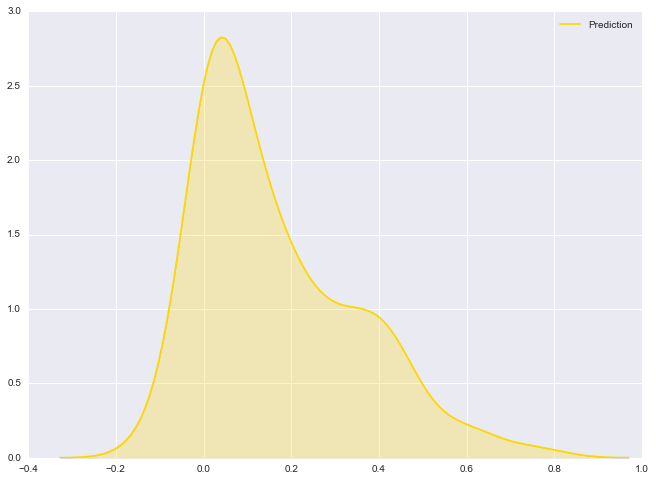

In [86]:
# Visual representation of predictions distribution.
fig = plt.figure(figsize=(11,8))
ax1 = fig.add_subplot(111)
sns.kdeplot(predict7['Prediction'], ax=ax1, shade=True, color='gold')

Residuals?

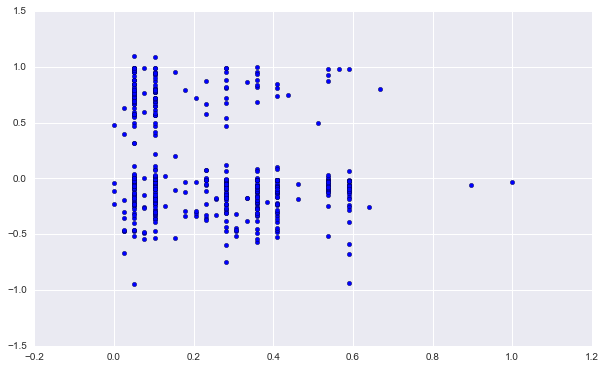

In [87]:
# Check residual plot for last donation (mo).
residue7 = lm7.resid
fig = plt.figure(figsize=(10,6))
ax1 = fig.add_subplot(111)
ax1.scatter(X_trn7_poly_num['last donation (mo)'], residue7.values)

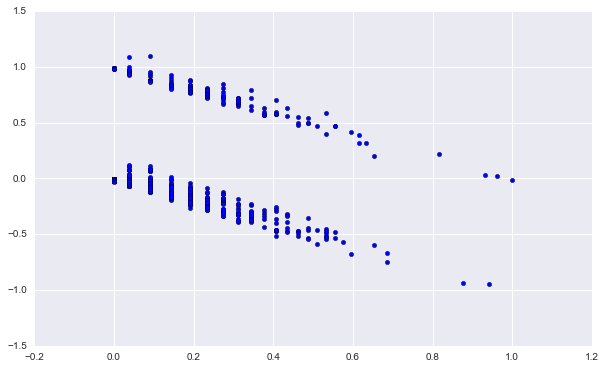

In [88]:
# Check residual plot for num donations squared.
residue7 = lm7.resid
fig = plt.figure(figsize=(10,6))
ax1 = fig.add_subplot(111)
ax1.scatter(X_trn7_poly_num['num donations squared'], residue7.values)

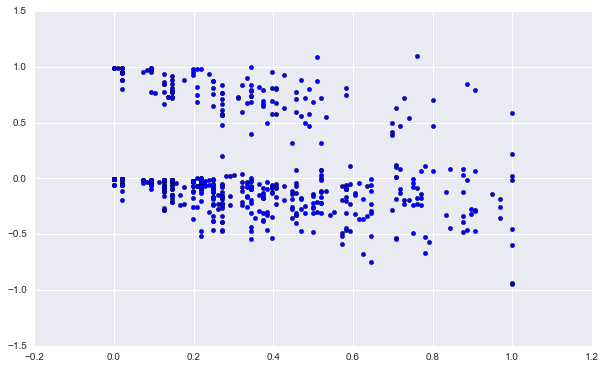

In [89]:
# Check residual plot for first donation (mo).
residue7 = lm7.resid
fig = plt.figure(figsize=(10,6))
ax1 = fig.add_subplot(111)
ax1.scatter(X_trn7_poly_num['first donation (mo)'], residue7.values)

## Part 2: Prediction ##

Though we did not find a perfect model, we will make a prediction on the test data using our best model, which (scorewise) was `lm3`.

In [90]:
# Write predictions to csv file.
predict3.to_csv('predictions.csv')

### Conclusion ###

All in all, our results were not good using a linear regression model. While we could have done a bit more feature engineering to see if we could get a better result, it is likely that this is the wrong model for the job.

One consequence of having a binary label is that our predicted values can end up outside the target range (and in fact, if we look at the predictions above, some do). This is because our regression model assumes that taking a linear combination of the feature coefficients is appropriate. When we have features that are continuous, this can often result in a predicted outcome that is too high or too low.

Given the binary outcome variable, we might have better luck with logistic regression, but it's an interesting exercise to see how well we can do with linear regression. Given more time, we might be able to find a somewhat decent linear model.